In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')
from ESINet.forward import create_forward_model, get_info
from ESINet.simulations import run_simulations, create_eeg
from ESINet.util import *
from ESINet.ann import *
from ESINet.viz import parula

pth_fwd_32 = 'forward_models/ico3_32chan/'
pth_fwd_64 = 'forward_models/ico3_64chan/'

info_32 = get_info(kind='biosemi32')
info_64 = get_info(kind='biosemi64')

In [2]:
create_forward_model(pth_fwd_32, sampling='ico3', info=info_32)
create_forward_model(pth_fwd_64, sampling='ico3', info=info_64)

Model already exists at path forward_models/ico3_32chan/
..\ESINet\forward\forward.py:135: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference('average', projection=True, verbose=0)
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Usin

In [3]:
settings = dict(n_simulations=100000,
                n_sources=(1, 5),   # Specify the range of number of present sources 
                extents=(1, 4),     # Specify the range of size of the sources (in neighborhood orders)
                amplitudes=(1, 100), # Specify the range of amplitudes (in nAm)
                shape='both',       # Shape can be 'flat', 'gaussian' or 'both'
                durOfTrial=0)       # ESINet works with single-instance data, i.e duration of the trial segments must be 0 here

# Calculate random brain activity base on settings:
sources_sim = run_simulations(pth_fwd_32, **settings)
# sources_sim_32 = run_simulations(pth_fwd_32, **settings)
# sources_sim_64 = run_simulations(pth_fwd_32, **settings)

# Calculate the corresponding EEG signals using the forward model and some noise
eeg_sim_32 = create_eeg(sources_sim, pth_fwd_32, snr=2, n_trials=20)
eeg_sim_64 = create_eeg(sources_sim, pth_fwd_64, snr=2, n_trials=20)


Run 100000 simulations...
..\ESINet\util\util.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array([np.array(d) for d in neighbors])


  0%|          | 0/100000 [00:00<?, ?it/s]

C:\Users\Lukas\Anaconda3\envs\esidev\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
has_temporal_dimension:False
return_single_epoch:True

Convert simulations to a single instance of mne.SourceEstimate...

Create EEG trials with noise...


  0%|          | 0/100000 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...
eeg_trials_noisy.shape=(100000, 20, 32, 1)

Create EEG trials with noise...


  0%|          | 0/100000 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...
eeg_trials_noisy.shape=(100000, 20, 256, 1)


## Train Model 1

In [4]:
# Find out input and output dimensions based on the shape of the leadfield 
input_dim, output_dim = load_leadfield(pth_fwd_32).shape
# Initialize the artificial neural network model.
model_32 = get_model(input_dim, output_dim, n_layers=1, n_neurons=128)
# Train the model
model_32, history = train_model(model_32, sources_sim, eeg_sim_32, delta=1, )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1284)              165636    
Total params: 169,860
Trainable params: 169,860
Non-trainable params: 0
_________________________________________________________________
C:\Users\Lukas\Anaconda3\envs\esidev\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/100
450/450 - 3s - loss: 0.0058 - huber_loss: 0.0058 - val_loss: 0.0052 - val_huber_loss: 0.0052
Epoch 2/100
450/450 - 1s - loss: 0.0050 - huber_loss: 0.0050 - val_loss: 0.0049 - val_huber_loss: 0.0049
Epoch 3/100
450/450 - 1s - loss: 0.0049 - huber_loss: 0.0049 - val_loss: 0.0048 - val_huber_loss:

## Train Model 2

In [29]:
# Find out input and output dimensions based on the shape of the leadfield 
input_dim, output_dim = load_leadfield(pth_fwd_64).shape
# Initialize the artificial neural network model.
model_64 = get_model(input_dim, output_dim, n_layers=1, n_neurons=128)
# Train the model
model_64, history = train_model(model_64, sources_sim, eeg_sim_64, delta=1, )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1284)              165636    
Total params: 215,044
Trainable params: 215,044
Non-trainable params: 0
_________________________________________________________________
C:\Users\Lukas\Anaconda3\envs\esidev\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/100
450/450 - 2s - loss: 0.0054 - huber_loss: 0.0054 - val_loss: 0.0046 - val_huber_loss: 0.0046
Epoch 2/100
450/450 - 1s - loss: 0.0045 - huber_loss: 0.0045 - val_l

## Visualize

In [31]:
import time
%matplotlib qt
settings['n_simulations'] = 1
# Simulate a brand new sample:
sources_eval = run_simulations(pth_fwd_32, **settings)
eeg_eval_32 = create_eeg(sources_eval, pth_fwd_32)
eeg_eval_64 = create_eeg(sources_eval, pth_fwd_64)

# Calculate the ERP (average across trials):
eeg_sample_32 = np.squeeze( eeg_eval_32 )
eeg_sample_64 = np.squeeze( eeg_eval_64 )

# Predict
source_predicted_32 = predict(model_32, eeg_sample_32, pth_fwd_32)
source_predicted_64 = predict(model_64, eeg_sample_64, pth_fwd_64)

# Visualize ground truth...
title = f'Ground Truth'
xx = sources_eval.plot(hemi='both', initial_time=0.5, surface='white', colormap=parula, title=title, time_viewer=False, backend='pyvista')

# ... and prediction with 32 chans
title = f'ConvDip Prediction 32'
yy = source_predicted_32.plot(hemi='both', initial_time=0.5, surface='white', colormap=parula, title=title, time_viewer=False, backend='pyvista')

title = f'ConvDip Prediction 64'
zz = source_predicted_64.plot(hemi='both', initial_time=0.5, surface='white', colormap=parula, title=title, time_viewer=False, backend='pyvista')


# ... and the 'True' EEG topography
title = f'Simulated EEG 32'
eeg_eval_32[0].average().plot_topomap([0], title=title, cmap=parula)

title = f'Simulated EEG 64'
eeg_eval_64[0].average().plot_topomap([0], title=title, cmap=parula)

print(f'\nInverse solution and pre- & postprocessing were calculated within {(end-start)*1000:.1f} ms')


Run 1 simulations...
..\ESINet\util\util.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array([np.array(d) for d in neighbors])


  0%|          | 0/1 [00:00<?, ?it/s]

has_temporal_dimension:False
return_single_epoch:True

Convert simulations to a single instance of mne.SourceEstimate...

Create EEG trials with noise...
C:\Users\Lukas\Anaconda3\envs\esidev\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


  0%|          | 0/1 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...
eeg_trials_noisy.shape=(1, 20, 32, 1)

Create EEG trials with noise...


  0%|          | 0/1 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...
eeg_trials_noisy.shape=(1, 20, 256, 1)
C:\Users\Lukas\Anaconda3\envs\esidev\lib\site-packages\scipy\optimize\_minimize.py:779: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
Using control points [0.00000000e+00 0.00000000e+00 1.13199284e-08]
Using control points [3.33463789e-10 2.36459355e-09 8.90510884e-09]
Using control points [0.00000000e+00 2.04938284e-09 1.10034122e-08]


NameError: name 'end' is not defined

In [ ]:
eeg_eval_32.plot_sensors(show_names=True)

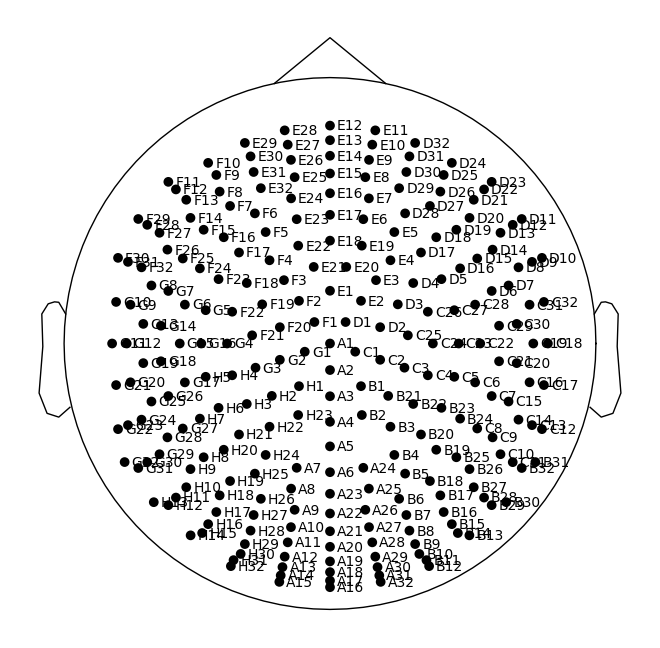

In [14]:
eeg_eval_64.plot_sensors(show_names=True)

## Get Mean Squared Error loss

In [32]:
settings['n_simulations'] = 1000
# Simulate a brand new sample:
sources_eval = run_simulations(pth_fwd_32, **settings)
eeg_eval_32 = create_eeg(sources_eval, pth_fwd_32)
eeg_eval_64 = create_eeg(sources_eval, pth_fwd_64)

# Calculate the ERP (average across trials):
eeg_sample_32 = np.squeeze( eeg_eval_32 )
eeg_sample_64 = np.squeeze( eeg_eval_64 )

# Predict
source_predicted_32 = predict(model_32, eeg_sample_32, pth_fwd_32)
source_predicted_64 = predict(model_64, eeg_sample_64, pth_fwd_64)


Run 1000 simulations...
..\ESINet\util\util.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array([np.array(d) for d in neighbors])


  0%|          | 0/1000 [00:00<?, ?it/s]

has_temporal_dimension:False
return_single_epoch:True

Convert simulations to a single instance of mne.SourceEstimate...

Create EEG trials with noise...
C:\Users\Lukas\Anaconda3\envs\esidev\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


  0%|          | 0/1000 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...
eeg_trials_noisy.shape=(1000, 20, 32, 1)

Create EEG trials with noise...


  0%|          | 0/1000 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...
eeg_trials_noisy.shape=(1000, 20, 256, 1)
C:\Users\Lukas\Anaconda3\envs\esidev\lib\site-packages\scipy\optimize\_minimize.py:779: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [35]:
mse_32 = np.mean((sources_eval.data - source_predicted_32.data)**2, axis=0)
mse_64 = np.mean((sources_eval.data - source_predicted_64.data)**2, axis=0)

import seaborn as sns
import pandas as pd

d = pd.DataFrame(dict(mse_32=mse_32, mse_64=mse_64))

sns.violinplot(data=d, kde=True)


C:\Users\Lukas\Anaconda3\envs\esidev\lib\site-packages\seaborn\categorical.py:365: UserWarning: Use the colorbar set_ticks() method instead.
  ax.set_xticks(np.arange(len(self.plot_data)))


ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of ticklabels (2).

In [37]:
np.median(mse_64) / np.median(mse_32)

0.7467695187175856

In [19]:
from scipy.stats import ttest_rel
ttest_rel(mse_32, mse_64)

Ttest_relResult(statistic=10.585227949298469, pvalue=6.855370557331875e-25)

In [ ]:
eeg_eval_32.plot_sensors(show_names=True)
eeg_eval_64.plot_sensors(show_names=True)